# Feature Selection
This notebook identifies the most important features for predicting Top 20 finishes in the Tour de France.

## Key Steps:
- Trains models on a range of feature sets and evaluates which models predict the best, based on accuracy, recall, f1 score, and AUC
- Checks for collinearity
- Uses SHAP to evaluate individual feature performance

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Scikit-learn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Statsmodels for collinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Joblib for saving/loading models
import joblib

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP for interpretability
import shap

## Set Folder Path and Read CSVs

In [2]:
def find_project_root(start: Path, anchor_dirs=("src", "Data")) -> Path:
    """
    Walk up the directory tree until we find a folder that
    contains all anchor_dirs (e.g. 'src' and 'Data').
    """
    path = start.resolve()
    for parent in [path] + list(path.parents):
        if all((parent / d).is_dir() for d in anchor_dirs):
            return parent
    raise FileNotFoundError("Could not locate project root")

In [3]:
# Locate the project root regardless of notebook depth
project_root = find_project_root(Path.cwd())

# ----- Code modules --------------------------------------------------
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_prep import preprocess_tdf_data   # import data preproc function

# ----- Data ----------------------------------------------------------
raw_data_path = project_root / "Data" / "Raw"
processed_data_path = project_root / "Data" / "Processed"
print("Raw data folder:", raw_data_path)
print("Processed data folder:", processed_data_path)

Raw data folder: C:\Users\Shaun Ricketts\Documents\GitHub\Tour-de-France-Top-20-Predictor\Data\Raw
Processed data folder: C:\Users\Shaun Ricketts\Documents\GitHub\Tour-de-France-Top-20-Predictor\Data\Processed


In [4]:
# Race metadata
prepared_df = pd.read_csv(processed_data_path / "tdf_prepared.csv")

In [7]:
# import missing_value_handler
from missing_value_handler import FillWithSentinel

In [8]:
cleaner = FillWithSentinel()
final_df = cleaner.fit_transform(prepared_df)

In [9]:
# Filter out DNF or DSQ from TDF_Pos
final_df = final_df[~final_df['TDF_Pos'].isin(['DNF', 'DSQ'])]

In [10]:
final_df = final_df.dropna(subset=['TDF_Pos'])

In [11]:
# Convert TDF_Pos to numeric
final_df['TDF_Pos'] = pd.to_numeric(final_df['TDF_Pos'])

# 1 if TDF_Pos <= 20, else 0
final_df['is_top20'] = (final_df['TDF_Pos'] <= 20).astype(int)

In [12]:
# Set date range for 2015+, and exclude 2020 & 2021
final_df = final_df[(final_df['Year'] >= 2015) & (~final_df['Year'].isin([2020, 2021]))]

In [13]:
final_df

,Rider_ID,Year,TDF_Pos,Best_Pos_BT_UWT,Best_Pos_BT_PT,Best_Pos_AT_UWT_YB,Best_Pos_AT_PT_YB,Best_Pos_UWT_YB,Best_Pos_PT_YB,FC_Points_YB,FC_Pos_YB,best_tdf_result,best_other_gt_result,best_recent_tdf_result,best_recent_other_gt_result,tdf_debut,gt_debut,rode_giro,Age,is_top20
5,3,2015,5.0,1.0,999,1.0,999,1.0,999,2893.0,2,1.0,1.0,4.0,1.0,0.0,0.0,1.0,33,1
7,3,2017,9.0,2.0,2.0,4.0,1.0,1.0,1.0,2095.0,8,1.0,1.0,5.0,1.0,0.0,0.0,0.0,35,1
25,8,2016,34.0,19.0,999,24.0,4.0,24.0,4.0,386.0,188,3.0,5.0,12.0,24.0,0.0,0.0,0.0,36,0
31,9,2016,84.0,35.0,26.0,13.0,9.0,13.0,9.0,302.0,229,14.0,12.0,999.0,18.0,0.0,0.0,0.0,32,0
51,13,2015,36.0,14.0,999,999,32.0,18.0,32.0,677.0,96,9.0,8.0,16.0,18.0,0.0,0.0,1.0,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20516,120433,2024,39.0,4.0,999,10.0,999,10.0,6.0,483.0,175,999.0,999.0,999.0,999.0,1.0,0.0,0.0,22,0
20610,126678,2024,41.0,13.0,999,42.0,999,15.0,1.0,1055.0,58,999.0,42.0,999.0,42.0,1.0,0.0,0.0,21,0
20802,153042,2024,23.0,12.0,9.0,999,7.0,60.0,7.0,110.0,393,999.0,999.0,999.0,999.0,1.0,0.0,0.0,25,0
20861,156417,2024,47.0,21.0,8.0,999,46.0,999,14.0,252.0,280,999.0,999.0,999.0,999.0,1.0,1.0,0.0,20,0


In [14]:
final_df.columns

Index(['Rider_ID', 'Year', 'TDF_Pos', 'Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'Best_Pos_AT_UWT_YB', 'Best_Pos_AT_PT_YB', 'Best_Pos_UWT_YB',
       'Best_Pos_PT_YB', 'FC_Points_YB', 'FC_Pos_YB', 'best_tdf_result',
       'best_other_gt_result', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'tdf_debut', 'gt_debut', 'rode_giro',
       'Age', 'is_top20'],
      dtype='object')

In [15]:
feature_sets = {
    "all_features": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'Best_Pos_AT_UWT_YB', 'Best_Pos_AT_PT_YB', 'Best_Pos_UWT_YB',
       'Best_Pos_PT_YB', 'FC_Pos_YB', 'best_tdf_result',
       'best_other_gt_result', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'tdf_debut', 'gt_debut', 'rode_giro',
       'Age'],
    
    "recent_gts_only": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'Best_Pos_UWT_YB','Best_Pos_PT_YB', 'FC_Pos_YB',
       'best_recent_tdf_result','best_recent_other_gt_result', 
       'rode_giro', 'Age'],
    
    "historic_gts_only": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'Best_Pos_UWT_YB','Best_Pos_PT_YB', 'FC_Pos_YB',
       'best_tdf_result','best_other_gt_result', 
       'rode_giro', 'tdf_debut', 'gt_debut', 'Age'],

    "no_YB": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'rode_giro', 'Age'],

    "drop_age": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'rode_giro'],

    "drop_giro": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result', 'Age'],

    "drop_giro_age": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result'],
    
    "no_PT": ['Best_Pos_BT_UWT', 
       'FC_Pos_YB', 'best_recent_tdf_result',
       'best_recent_other_gt_result'],

    "only_bt_recent_res": ['Best_Pos_BT_UWT', 'Best_Pos_BT_PT',
       'best_recent_tdf_result',
       'best_recent_other_gt_result'],

    "only_bt_recent_res_no_PT": ['Best_Pos_BT_UWT',
       'best_recent_tdf_result',
       'best_recent_other_gt_result']

}


In [16]:
# ---------------------------------------------------------------------------
# 1)  Prep: masks, CV splitter, param grid (as you already had)
# ---------------------------------------------------------------------------
train_mask = (final_df['Year'] >= 2012) & (final_df['Year'] <= 2023)
test_mask  = (final_df['Year'] == 2024)

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth':   [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf':  [1, 2],
}


In [17]:

# ---------------------------------------------------------------------------
# 2)  Containers so each model/df has its own name
# ---------------------------------------------------------------------------
models          = {}   # trained estimators
X_test_sets     = {}   # test-set predictors, per FS
feature_columns = {}   # list of feature names, per FS
shap_matrices   = {}   # optional: cache SHAP matrices so you compute once

perf_rows  = []
rider_preds_df = final_df.loc[test_mask, ['Rider_ID', 'TDF_Pos']].copy()

In [18]:
# ---------------------------------------------------------------------------
# 3)  Train & store everything keyed by the feature-set name
# ---------------------------------------------------------------------------
for name, features in feature_sets.items():
    print(f"\n{'='*22} Evaluating feature set: {name} {'='*22}\n")
    
    X_train = final_df.loc[train_mask, features]
    y_train = final_df.loc[train_mask, 'is_top20']
    X_test  = final_df.loc[test_mask,  features]
    y_test  = final_df.loc[test_mask,  'is_top20']
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', RandomForestClassifier(random_state=42,
                                              class_weight='balanced'))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=cv_splitter, scoring='roc_auc',
        n_jobs=-1, verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    
    # ─── store the model & data ────────────────────────────────────────────
    models[name]          = best_clf
    X_test_sets[name]     = X_test
    feature_columns[name] = features
    
    # ─── evaluation bookkeeping (unchanged) ───────────────────────────────
    y_pred  = best_clf.predict(X_test)
    y_probs = best_clf.predict_proba(X_test)[:, 1]
    
    perf_rows.append({
        "Feature Set":    name,
        "Accuracy":       round(accuracy_score(y_test, y_pred), 3),
        "F1 (class 1)":   round(f1_score(y_test, y_pred, pos_label=1), 3),
        "Recall (class 1)": round(recall_score(y_test, y_pred, pos_label=1), 3),
        "AUC":            round(roc_auc_score(y_test, y_probs), 3),
    })
    rider_preds_df[name] = y_probs
    
    # ─── console output (optional) ────────────────────────────────────────
    print(f"Best Parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"AUC Score on Test Set: {perf_rows[-1]['AUC']}\n")


====================== Evaluating feature set: all_features ======================

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       121
           1       0.71      0.75      0.73        20

    accuracy                           0.92       141
   macro avg       0.84      0.85      0.84       141
weighted avg       0.92      0.92      0.92       141

Confusion Matrix:
 [[115   6]
 [  5  15]]
AUC Score on Test Set: 0.952


====================== Evaluating feature set: recent_gts_only ======================

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       121
           1   

In [19]:
performance_df = pd.DataFrame(perf_rows).sort_values(
    by=["F1 (class 1)", "AUC"], ascending=False
)

In [20]:
# Get the best feature set for each performance score
best_accuracy = performance_df.loc[performance_df["Accuracy"].idxmax()]
best_f1 = performance_df.loc[performance_df["F1 (class 1)"].idxmax()]
best_recall = performance_df.loc[performance_df["Recall (class 1)"].idxmax()]
best_auc = performance_df.loc[performance_df["AUC"].idxmax()]

In [21]:
metrics = ["Accuracy", "F1 (class 1)", "Recall (class 1)", "AUC"]

In [22]:
for metric in metrics:
    top3 = performance_df.nlargest(3, metric)["Feature Set"]
    print(f"Top 3 for {metric}: {', '.join(top3)}")

Top 3 for Accuracy: drop_giro, recent_gts_only, no_YB
Top 3 for F1 (class 1): drop_giro, recent_gts_only, no_YB
Top 3 for Recall (class 1): drop_giro, recent_gts_only, no_YB
Top 3 for AUC: drop_age, recent_gts_only, all_features


In [23]:
performance_df

,Feature Set,Accuracy,F1 (class 1),Recall (class 1),AUC
5,drop_giro,0.936,0.769,0.75,0.945
1,recent_gts_only,0.929,0.750,0.75,0.954
3,no_YB,0.929,0.750,0.75,0.951
6,drop_giro_age,0.929,0.737,0.70,0.943
4,drop_age,0.922,0.732,0.75,0.955
0,all_features,0.922,0.732,0.75,0.952
9,only_bt_recent_res_no_PT,0.908,0.698,0.75,0.948
2,historic_gts_only,0.901,0.667,0.70,0.948
7,no_PT,0.908,0.667,0.65,0.933
8,only_bt_recent_res,0.887,0.619,0.65,0.944


In [24]:
rider_preds_df.sort_values(by='TDF_Pos', ascending=True).head(20)

,Rider_ID,TDF_Pos,all_features,recent_gts_only,historic_gts_only,no_YB,drop_age,drop_giro,drop_giro_age,no_PT,only_bt_recent_res,only_bt_recent_res_no_PT
17407,45992,1.0,0.919582,0.917893,0.890593,0.924777,0.874847,0.961542,0.967936,0.964983,0.943912,0.976413
16616,38195,2.0,0.980110,0.988234,0.989420,0.992792,0.989966,0.982410,0.984644,0.989499,0.978383,0.954114
19664,84019,3.0,0.778135,0.785228,0.810846,0.771319,0.766742,0.786936,0.718369,0.819825,0.678055,0.830017
17859,50303,4.0,0.688290,0.855665,0.813048,0.772539,0.837668,0.756572,0.704868,0.751083,0.807568,0.855059
5187,2278,5.0,0.794104,0.867171,0.890602,0.764538,0.931090,0.758613,0.868122,0.870475,0.822739,0.902525
13660,20147,6.0,0.948283,0.955982,0.974050,0.920059,0.958447,0.885423,0.840669,0.953896,0.827429,0.960422
19678,84926,7.0,0.882017,0.794340,0.864739,0.855875,0.903976,0.843693,0.805388,0.734491,0.911861,0.919929
18873,68206,8.0,0.663473,0.800981,0.691199,0.769315,0.832658,0.772899,0.753491,0.801130,0.653245,0.776718
16323,37421,9.0,0.132298,0.204365,0.145342,0.290933,0.218773,0.195011,0.166577,0.121023,0.221203,0.241846
19558,81835,10.0,0.645971,0.547524,0.621290,0.691936,0.588794,0.605716,0.491884,0.558859,0.595275,0.668557


In [25]:
rider_preds_df.sort_values(by='drop_giro_age', ascending=False).head(20)

,Rider_ID,TDF_Pos,all_features,recent_gts_only,historic_gts_only,no_YB,drop_age,drop_giro,drop_giro_age,no_PT,only_bt_recent_res,only_bt_recent_res_no_PT
16616,38195,2.0,0.980110,0.988234,0.989420,0.992792,0.989966,0.982410,0.984644,0.989499,0.978383,0.954114
17407,45992,1.0,0.919582,0.917893,0.890593,0.924777,0.874847,0.961542,0.967936,0.964983,0.943912,0.976413
5187,2278,5.0,0.794104,0.867171,0.890602,0.764538,0.931090,0.758613,0.868122,0.870475,0.822739,0.902525
7696,6242,12.0,0.904405,0.900827,0.865799,0.898577,0.911777,0.864176,0.866570,0.810472,0.757089,0.795551
4259,1527,19.0,0.873631,0.894414,0.903548,0.937997,0.923565,0.896545,0.858185,0.856131,0.942058,0.965908
13660,20147,6.0,0.948283,0.955982,0.974050,0.920059,0.958447,0.885423,0.840669,0.953896,0.827429,0.960422
5153,2275,30.0,0.751078,0.738865,0.685886,0.743524,0.739468,0.772122,0.818554,0.833840,0.867450,0.904993
2503,716,42.0,0.702498,0.732962,0.672846,0.644160,0.767193,0.730636,0.809674,0.752112,0.942216,0.968642
19678,84926,7.0,0.882017,0.794340,0.864739,0.855875,0.903976,0.843693,0.805388,0.734491,0.911861,0.919929
18873,68206,8.0,0.663473,0.800981,0.691199,0.769315,0.832658,0.772899,0.753491,0.801130,0.653245,0.776718


Top Performing Models:
1. drop_giro
2. recent_gts_only
3. no_YB
4. drop_giro_age 
5. drop_age
6. all_features

drop_giro has the highest F1 and Accuracy, tied for highest on Recall. recent_gts_only and no_YB are also strong candidates.

In [26]:
feature_sets_to_analyse = ["drop_giro", "recent_gts_only", "no_YB", 
                        "drop_giro_age", "drop_age", "all_features"]

## Checking Collinearity

In [27]:
def corr_pairs_table(df, top_n=20):
    """
    Returns a DataFrame of the top_n absolute-value correlations
    between every pair of numeric columns in df.
    """
    corr = df.corr().stack().reset_index()
    corr.columns = ["feature_1", "feature_2", "corr"]

    # remove self-correlations
    corr = corr[corr["feature_1"] != corr["feature_2"]]

    # drop duplicate pairs (A,B) vs (B,A)
    corr["pair_sorted"] = corr.apply(
        lambda x: tuple(sorted((x["feature_1"], x["feature_2"]))), axis=1
    )
    corr = corr.drop_duplicates("pair_sorted").drop(columns="pair_sorted")

    # sort by absolute correlation
    corr = corr.reindex(corr["corr"].abs().sort_values(ascending=False).index)

    return corr.head(top_n)


In [28]:
for fs in feature_sets_to_analyse:
    print(f"\nTop correlations for feature set: {fs}")
    display(corr_pairs_table(X_test_sets[fs], top_n=15))


Top correlations for feature set: drop_giro


,feature_1,feature_2,corr
23,best_recent_tdf_result,Age,-0.497489
4,Best_Pos_BT_UWT,best_recent_other_gt_result,0.275685
15,FC_Pos_YB,best_recent_tdf_result,0.268751
1,Best_Pos_BT_UWT,Best_Pos_BT_PT,-0.140993
8,Best_Pos_BT_PT,FC_Pos_YB,-0.138328
10,Best_Pos_BT_PT,best_recent_other_gt_result,-0.111825
17,FC_Pos_YB,Age,0.099906
29,best_recent_other_gt_result,Age,-0.098817
22,best_recent_tdf_result,best_recent_other_gt_result,-0.079519
11,Best_Pos_BT_PT,Age,-0.073160



Top correlations for feature set: recent_gts_only


,feature_1,feature_2,corr
53,best_recent_tdf_result,Age,-0.497489
24,Best_Pos_UWT_YB,best_recent_other_gt_result,0.385271
23,Best_Pos_UWT_YB,best_recent_tdf_result,0.300482
6,Best_Pos_BT_UWT,best_recent_other_gt_result,0.275685
22,Best_Pos_UWT_YB,FC_Pos_YB,0.274595
41,FC_Pos_YB,best_recent_tdf_result,0.268751
71,rode_giro,Age,0.234761
11,Best_Pos_BT_PT,Best_Pos_UWT_YB,-0.218525
12,Best_Pos_BT_PT,Best_Pos_PT_YB,0.216734
26,Best_Pos_UWT_YB,Age,-0.205752



Top correlations for feature set: no_YB


,feature_1,feature_2,corr
27,best_recent_tdf_result,Age,-0.497489
4,Best_Pos_BT_UWT,best_recent_other_gt_result,0.275685
17,FC_Pos_YB,best_recent_tdf_result,0.268751
41,rode_giro,Age,0.234761
26,best_recent_tdf_result,rode_giro,-0.171874
1,Best_Pos_BT_UWT,Best_Pos_BT_PT,-0.140993
9,Best_Pos_BT_PT,FC_Pos_YB,-0.138328
11,Best_Pos_BT_PT,best_recent_other_gt_result,-0.111825
20,FC_Pos_YB,Age,0.099906
34,best_recent_other_gt_result,Age,-0.098817



Top correlations for feature set: drop_giro_age


,feature_1,feature_2,corr
4,Best_Pos_BT_UWT,best_recent_other_gt_result,0.275685
13,FC_Pos_YB,best_recent_tdf_result,0.268751
1,Best_Pos_BT_UWT,Best_Pos_BT_PT,-0.140993
7,Best_Pos_BT_PT,FC_Pos_YB,-0.138328
9,Best_Pos_BT_PT,best_recent_other_gt_result,-0.111825
19,best_recent_tdf_result,best_recent_other_gt_result,-0.079519
3,Best_Pos_BT_UWT,best_recent_tdf_result,-0.045516
2,Best_Pos_BT_UWT,FC_Pos_YB,-0.033915
8,Best_Pos_BT_PT,best_recent_tdf_result,-0.011803
14,FC_Pos_YB,best_recent_other_gt_result,-0.007642



Top correlations for feature set: drop_age


,feature_1,feature_2,corr
4,Best_Pos_BT_UWT,best_recent_other_gt_result,0.275685
15,FC_Pos_YB,best_recent_tdf_result,0.268751
23,best_recent_tdf_result,rode_giro,-0.171874
1,Best_Pos_BT_UWT,Best_Pos_BT_PT,-0.140993
8,Best_Pos_BT_PT,FC_Pos_YB,-0.138328
10,Best_Pos_BT_PT,best_recent_other_gt_result,-0.111825
22,best_recent_tdf_result,best_recent_other_gt_result,-0.079519
3,Best_Pos_BT_UWT,best_recent_tdf_result,-0.045516
2,Best_Pos_BT_UWT,FC_Pos_YB,-0.033915
5,Best_Pos_BT_UWT,rode_giro,-0.026817



Top correlations for feature set: all_features


,feature_1,feature_2,corr
116,best_tdf_result,tdf_debut,0.962437
114,best_tdf_result,best_recent_tdf_result,0.863800
146,best_recent_tdf_result,tdf_debut,0.819399
72,Best_Pos_UWT_YB,gt_debut,0.678938
130,best_other_gt_result,best_recent_other_gt_result,0.660015
119,best_tdf_result,Age,-0.608983
179,tdf_debut,Age,-0.595675
68,Best_Pos_UWT_YB,best_other_gt_result,0.521692
132,best_other_gt_result,gt_debut,0.510677
149,best_recent_tdf_result,Age,-0.497489


 
- Unsurprisingly very high correlations in the "all_features" set across multiple columns
- Moderate correlation between "best_recent_tdf_result" and "Age" (about -0.5), I expect this is because a lot of young riders will have no result, hence 999. This moderate correlation may cause some redundancy in the Age column, so I will consider removing it. Interestingly this does not appear to be the case with best_recent_other_gt_result vs Age, suggesting that young riders may do a Giro d'Italia or Vuelta Espana prior to their first TdF.
- Moderate  correlations with Best_Pos_UWT_YB and Best_Pos_BT_UWT vs best_recent_tdf_result and best_recent_other_gt_result. Makes sense since riders who do well in 1-week World-Tour races are likely to be stronger in 3-week Grand Tours.
- No other correlations are a major concern

Decisions:
- Avoid picking feature sets with Age as it is too highly correlated with best_recent_tdf_result
- These leaves drop_giro_age and drop_age as the two main candidates

In [29]:
# Remove "all_features" for shap plots
feature_sets_to_analyse = ["drop_giro_age", "drop_age"]

- drop_giro_age has a slightly higher Accuracy and F1 score
- drop_age has a slightly higher recall and AUC
- Minimal differences between them here
- The two feature sets contain the same columns, besides drop_age including "rode_giro"

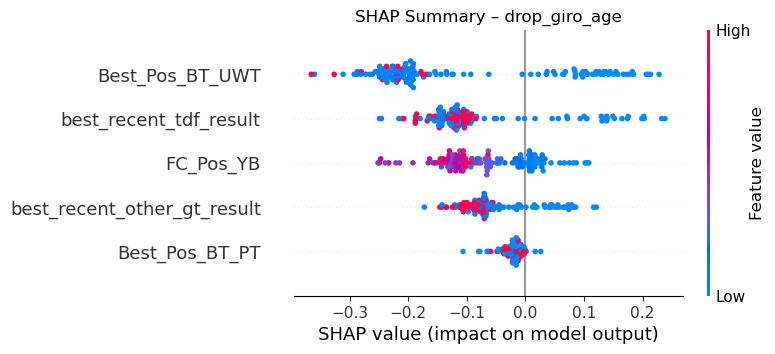

In [30]:
fs = "drop_giro_age"
pipe = models[fs]
rf = pipe.named_steps["classifier"]
imputer = pipe.named_steps["imputer"]

# Get raw test data
X_test_raw = X_test_sets[fs][feature_columns[fs]]

# Apply imputation manually for plotting
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=feature_columns[fs])

# Get SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_imputed)
shap_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values[:, :, 1]

# Plot with imputed (but raw value-like) data
shap.summary_plot(
    shap_matrix,
    features=X_test_imputed,
    feature_names=feature_columns[fs],
    show=False
)
plt.title(f"SHAP Summary – {fs}")
plt.show()


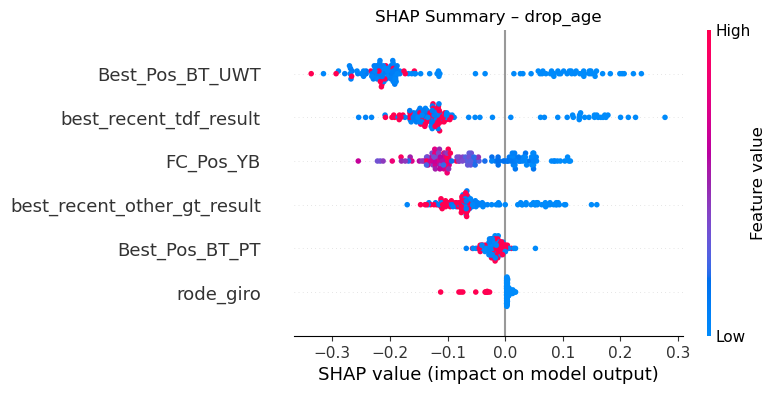

In [31]:
fs = "drop_age"
pipe = models[fs]
rf = pipe.named_steps["classifier"]
imputer = pipe.named_steps["imputer"]

# Get raw test data
X_test_raw = X_test_sets[fs][feature_columns[fs]]

# Apply imputation manually for plotting
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=feature_columns[fs])

# Get SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_imputed)
shap_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values[:, :, 1]

# Plot with imputed (but raw value-like) data
shap.summary_plot(
    shap_matrix,
    features=X_test_imputed,
    feature_names=feature_columns[fs],
    show=False
)
plt.title(f"SHAP Summary – {fs}")
plt.show()


- For these models, a positive SHAP value means more likely to be top20, negative means less (0 being 50/50%).
- We can see that for both cases, high feature values are almost always negative, so the model will only view 

- The only difference between the two feature sets is that drop_age has the additional column "rode_giro"
- The initial 5 cols are largely the same, slightly fewer high-values when rode_giro added, but it's minimal


Best_Pos_BT_UWT:
- A few red values indicates most riders results in this field do not impact their score, so not having an amazing position before the TdF in World-Tour races doesn't necessarily mean the model will predict them less likely for a top20, but riders who do have a very bad result are very likely to have a bad Tour as well.
- Has the widest range of SHAP values, showing it's a strong predictor

best_recent_tdf_result:
- Similar to above with more high-value results, but slightly less impactful to the model

FC_Pos_YB:
- Having a bad position in the ranking from the previous year will impact a lot

best_recent_other_gt_result:
- similar to best_recent_tdf_result but slightly less impactful to the model

Best_Pos_BT_PT:
- Very small range so not so impactful to the model, but many more red dots than Best_Pos_BT_UWT, so perhaps fills in context where UWT missing

rode_giro:
- Binary value, so if 1 (yes), has high-value negative impact, not too strong but enough to have an affect. 0 (no) has little affect in most cases which is fine

Decision:
- Based on the model testing and scores, particularly F1 and Recall, collinearity checks and SHAP summaries, I have decided to use the "drop_age" feature set going forward to model testing.